In [1]:
import os
import sys
import numpy as np
import pandas as pd

sys.path.append('../')
sys.path.append('../src/')
sys.path.append('../spell/')

import Reader
import ParamsExtractor3
import DataPreprocessor
import EncodeCommand
import DeepLearningAnomalyDetection2

2024-08-05 07:39:02.201470: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 07:39:02.251990: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 07:39:03.054705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
file_paths = ['../data/laurel_short_' + str(i) for i in range(8)]
existing_file_paths = [path for path in file_paths if os.path.exists(path)]
print(existing_file_paths)

anomalous_fp = '../data/laurel_short_anomalous'

['../data/laurel_short_0', '../data/laurel_short_1', '../data/laurel_short_2', '../data/laurel_short_3', '../data/laurel_short_4', '../data/laurel_short_5', '../data/laurel_short_6', '../data/laurel_short_7']


In [3]:
df_list = []

for f in existing_file_paths:
    df = pd.read_csv(f)
    df_list.append(df)

anomalous_df = pd.read_csv(anomalous_fp)

In [4]:
df_list[0].head(3)

,severity_scores,timedelta,suid,cap_fp,exit,n_dang,n_dang_no_cron,fp_length,col_0,col_1,...,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,enc_comm,enc_parent_comm
0,1.0,0.0,126858,0,0,2,0,92,0,0,...,0,0,0,0,1,0,0,0,1,39
1,1.0,0.0,0,0,0,0,0,38,0,0,...,0,0,0,0,1,0,0,0,2,82
2,1.0,0.0,0,0,0,0,0,28,0,0,...,0,0,0,0,1,0,0,0,3,2


In [5]:
anomalous_df.head(3)

,timedelta,suid,cap_fp,exit,log key,n_dang,n_dang_no_cron,fp_length,enc_comm,enc_parent_comm
0,NaN,998,0,0,-1,0,0,0,1,21
1,0.044,998,0,0,-1,0,0,0,1,21
2,-0.175,42,0,0,-1,0,0,0,2,21


In [6]:
def preprocess_suid_col(df):
    suid_list = df['suid']
    suid_new = [0 if suid_list[i] == 0 else 1 for i in range(len(suid_list))]
    df['suid'] = suid_new

In [7]:
def preprocess_timedelta(df):
    l = df['timedelta']
    l_new = [abs(x) if not pd.isna(x) else -1 for x in l]
    df['timedelta'] = l_new

In [8]:
for df in df_list:
    preprocess_suid_col(df)
    preprocess_timedelta(df)

In [9]:
df_list[0].head()

,severity_scores,timedelta,suid,cap_fp,exit,n_dang,n_dang_no_cron,fp_length,col_0,col_1,...,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,enc_comm,enc_parent_comm
0,1.0,0.0,1,0,0,2,0,92,0,0,...,0,0,0,0,1,0,0,0,1,39
1,1.0,0.0,0,0,0,0,0,38,0,0,...,0,0,0,0,1,0,0,0,2,82
2,1.0,0.0,0,0,0,0,0,28,0,0,...,0,0,0,0,1,0,0,0,3,2
3,1.0,0.0,0,0,0,0,0,28,0,0,...,0,0,0,0,1,0,0,0,4,2
4,1.0,0.0,0,0,0,0,0,21,0,0,...,0,0,0,0,1,0,0,0,5,2


In [10]:
preprocess_suid_col(anomalous_df)
preprocess_timedelta(anomalous_df)

In [11]:
anomalous_df.head()

,timedelta,suid,cap_fp,exit,log key,n_dang,n_dang_no_cron,fp_length,enc_comm,enc_parent_comm
0,-1.000,1,0,0,-1,0,0,0,1,21
1,0.044,1,0,0,-1,0,0,0,1,21
2,0.175,1,0,0,-1,0,0,0,2,21
3,0.129,1,0,0,-1,0,0,0,3,21
4,0.124,1,0,0,-1,0,0,0,4,21


In [12]:
columns_for_laurel = anomalous_df.columns
anomalous_dataset_encoded = anomalous_df

In [13]:
normal_dataset = df_list[0]

for i in range(1,len(df_list)):
    normal_dataset = np.vstack([normal_dataset, df_list[i]])
    
print(normal_dataset)
normal_df_encoded = pd.DataFrame(normal_dataset, columns=df_list[0].columns)
normal_df_encoded.head()

[[ 1.  0.  1. ...  0.  1. 39.]
 [ 1.  0.  0. ...  0.  2. 82.]
 [ 1.  0.  0. ...  0.  3.  2.]
 ...
 [ 1.  0.  0. ...  0.  8.  8.]
 [ 1.  0.  0. ...  0.  8. 97.]
 [ 1.  0.  0. ...  0. 20.  8.]]


,severity_scores,timedelta,suid,cap_fp,exit,n_dang,n_dang_no_cron,fp_length,col_0,col_1,...,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,enc_comm,enc_parent_comm
0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,92.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,39.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,82.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,2.0


In [14]:
columns_for_laurel

Index(['timedelta', 'suid', 'cap_fp', 'exit', 'log key', 'n_dang',
       'n_dang_no_cron', 'fp_length', 'enc_comm', 'enc_parent_comm'],
      dtype='object')

In [15]:
normal_dataset_df = pd.DataFrame(normal_df_encoded, columns=columns_for_laurel)
normal_dataset_df.fillna(-1, inplace=True)
anomalous_dataset_df = pd.DataFrame(anomalous_dataset_encoded, columns=columns_for_laurel)
#anomalous_dataset_df.fillna(0, inplace=True)

In [16]:
normal_dataset_df.head()

,timedelta,suid,cap_fp,exit,log key,n_dang,n_dang_no_cron,fp_length,enc_comm,enc_parent_comm
0,0.0,1.0,0.0,0.0,-1.0,2.0,0.0,92.0,1.0,39.0
1,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,38.0,2.0,82.0
2,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,28.0,3.0,2.0
3,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,28.0,4.0,2.0
4,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,21.0,5.0,2.0


Mean normal reconstruction error: 0.009135753362006909
Mean anomalous reconstruction error: 0.01883418408010473


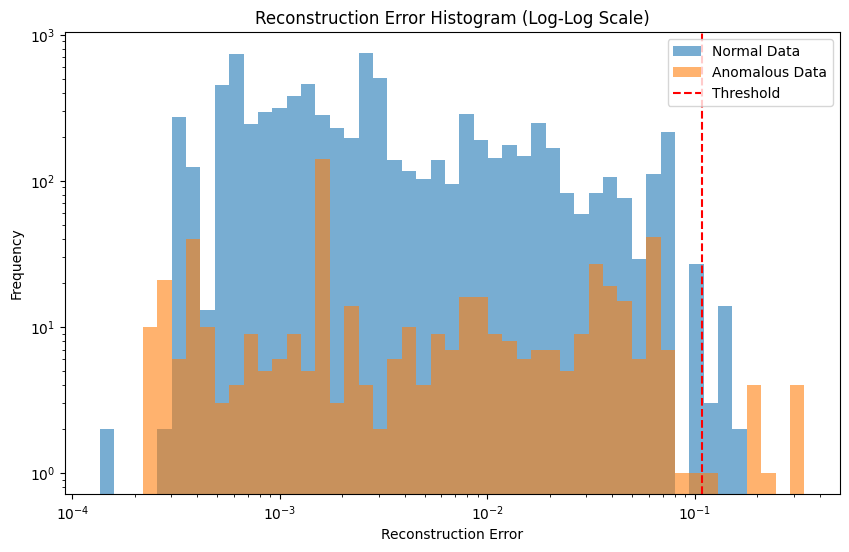

Threshold for anomaly detection: 0.10798073971356795
Number of anomalies detected: 10
Number of false positives detected: 20


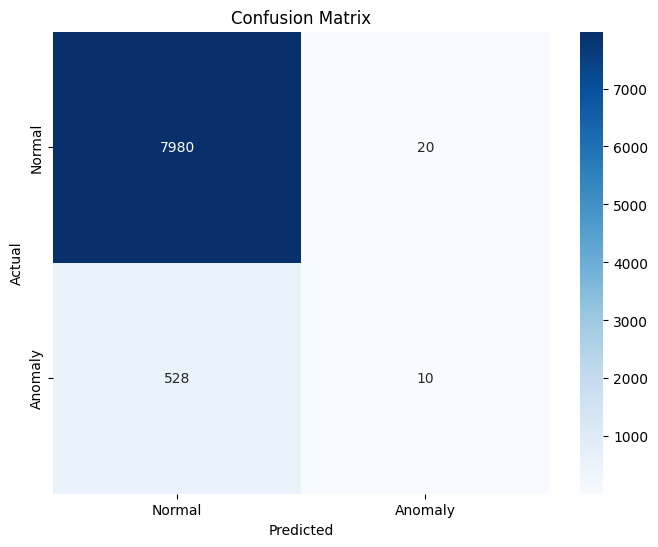

In [17]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(normal_dataset_df, anomalous_dataset_df, 'autoencoder', laurel=1, plots=[0,0,1,1])